In [107]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2

from ultralytics import YOLO
import torch


In [175]:
video_path  = os.path.join(os.getcwd(), 'src','classroom.mp4')

In [172]:
model = YOLO('yolov8n.pt')

In [174]:
results = model(image_path, conf=0.25, classes=[0])

In [ ]:
masks = process_frame()

In [198]:
def process_frame(frame):
    results = model(frame, conf=0.25, classes=[0])
    
    ## Process results
    for result in results:
        boxes = result.boxes
        total_classes = result.names
        
    bbox = boxes.xyxy
    print("bbox: ", bbox.shape)
    confidences = boxes.conf
    classes = boxes.cls 
    #predictor = SamPredictor(sam)
    predictor.set_image(frame)
    
    input_boxes = bbox.to(predictor.device)
    transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, frame.shape[:2])
    
    masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
    )
    
    return masks

In [204]:
def show_mask(masks, random_color=False):
    
    mask_images = []
    for mask in masks:
        print(mask.unique(), mask.shape)
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask_images.append(mask.reshape(h, w, 1) * color.reshape(1, 1, -1))
        
    print(np.array(mask_images).shape)
    combined_mask = np.sum(np.array(mask_images), axis=0)
    return combined_mask

In [205]:
cap = cv2.VideoCapture(video_path)

if cap.isOpened() == False:
    print("Error in loading the video")
    
i = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    
    masks = process_frame(frame)
    
    colour_mask = show_mask(masks)
    # frame = frame + colour_mask*0.3
    
    #dispaly frame and colour mask in same window
    frame = ((frame/np.max(frame))*255).astype(np.uint8)
    print(colour_mask.shape, frame.shape)
    colour_mask = cv2.addWeighted(colour_mask.astype(np.uint8), 0.3, frame, 0.7, 0, colour_mask.astype(np.uint8))
    #cv2.imshow('frame', frame)
    cv2.imshow('frame', colour_mask)
    
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

    
    print(i)
    i = i + 1

    

cap.release()
cv2.destroyAllWindows()

0: 384x640 8 persons, 53.0ms
Speed: 2.0ms preprocess, 53.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


bbox:  torch.Size([8, 4])
tensor([False,  True]) torch.Size([1, 480, 852])
tensor([False,  True]) torch.Size([1, 480, 852])
tensor([False,  True]) torch.Size([1, 480, 852])
tensor([False,  True]) torch.Size([1, 480, 852])
tensor([False,  True]) torch.Size([1, 480, 852])
tensor([False,  True]) torch.Size([1, 480, 852])
tensor([False,  True]) torch.Size([1, 480, 852])
tensor([False,  True]) torch.Size([1, 480, 852])
(8, 480, 852, 4)
(480, 852, 4) (480, 852, 3)


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:650: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'


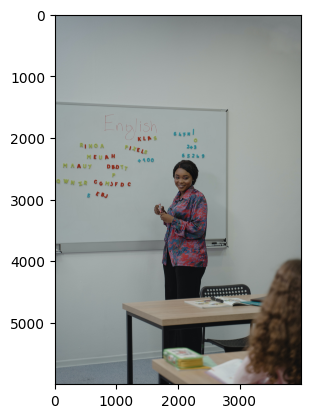

In [102]:
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

plt.imshow(image)

In [163]:
for result in results:
    boxes = result.boxes
    total_classes = result.names
   
    

bbox = boxes.xyxy
confidences = boxes.conf
classes = boxes.cls

    

In [74]:
classes = [total_classes[int(i)] for i in classes]
classes

['person', 'person']

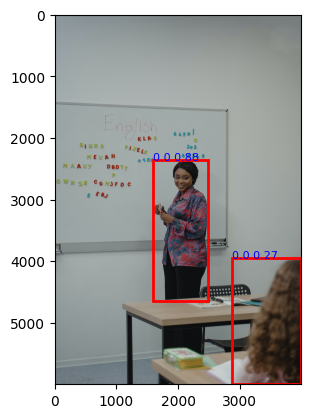

In [159]:
## show image with bounding boxes with labels and confidence scores
def show_image(image, boxes, classes, confidences):
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1
        patch = plt.Rectangle([x1, y1], w, h, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(patch)
        ax.text(x1, y1, s=f'{classes[i]} {confidences[i]:.2f}', color='blue', fontsize=8)
    plt.show()

show_image(image, bbox, classes, confidences)
    

## Segmentation

In [88]:
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

In [82]:
sam_checkpoints = "checkpoints"
vit_h = "sam_vit_h_4b8939.pth"
vit_b = "sam_vit_b_01ec64.pth"
vit_l = "sam_vit_l_0b3195.pth"

In [87]:
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=os.path.join(sam_checkpoints, vit_h))

device = "cuda" if torch.cuda.is_available() else "cpu"
sam = sam.to(device)

In [103]:
predictor = SamPredictor(sam)
predictor.set_image(image)

In [168]:
#input_boxes = torch.tensor(boxes).to(predictor.device)
input_boxes = bbox.to(predictor.device)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])

In [169]:
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

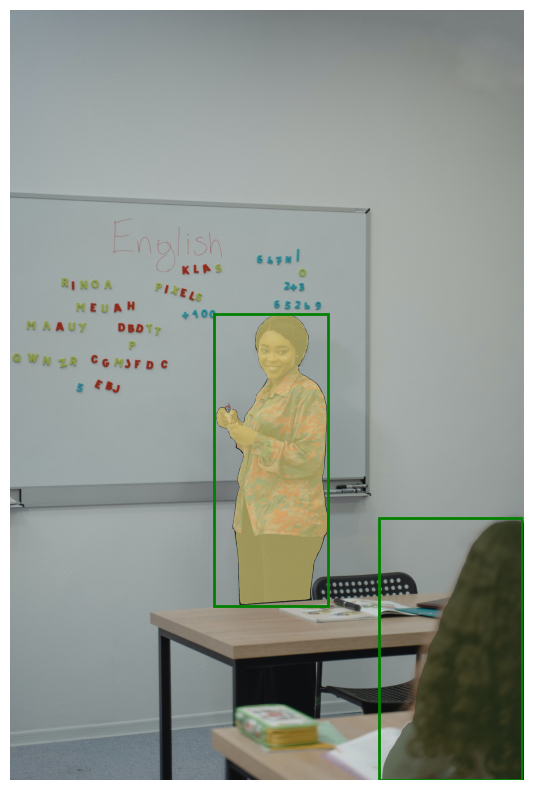

In [170]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [104]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    